# Final Project Model

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

### 1. Generate 14bits ideal ADC to test SNR

simulation SNR: 85.93 dB
theoritical model SNR: 86.04 dB


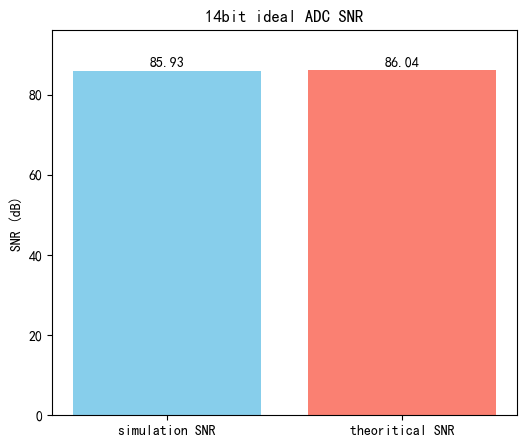

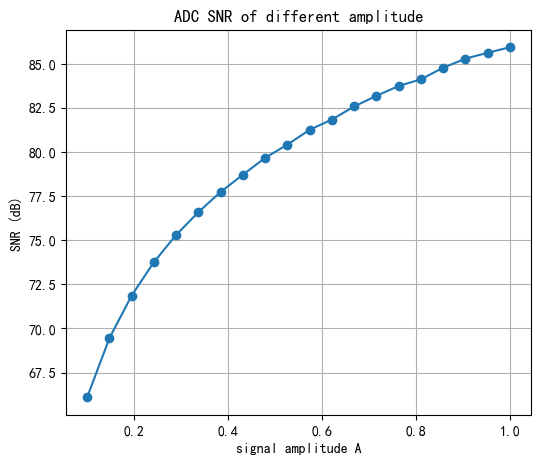

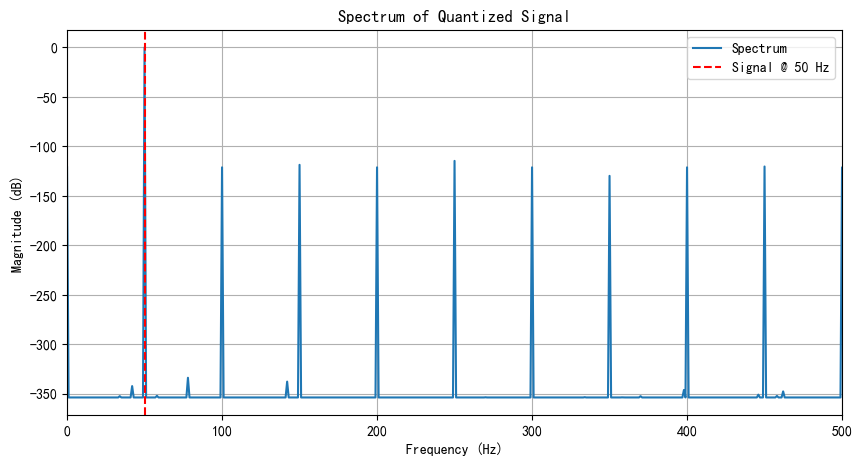

In [8]:
def first_generate_Ideal_ADC_Model():

    bits = 14               
    full_scale = 1.0        
    N = 1000000            
    f_signal = 50           
    t = np.linspace(0, 1, N, endpoint=False)  
    x = full_scale * np.sin(2 * np.pi * f_signal * t)
    Q = 2 * full_scale / (2**bits)


    x_quant = np.clip(np.round(x / Q) * Q, -full_scale, full_scale - Q)

    error = x - x_quant

    signal_power = np.mean(x**2)
    noise_power = np.mean(error**2)

    snr_simulated = 10 * np.log10(signal_power / noise_power)

    snr_theoretical = 6.02 * bits + 1.76

    print("simulation SNR: {:.2f} dB".format(snr_simulated))
    print("theoritical model SNR: {:.2f} dB".format(snr_theoretical))

    plt.figure(figsize=(6,5))
    bars = plt.bar(["simulation SNR", "theoritical SNR"], [snr_simulated, snr_theoretical], 
                color=['skyblue', 'salmon'])
    plt.ylabel("SNR (dB)")
    plt.title("14bit ideal ADC SNR")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom')
    plt.ylim(0, snr_theoretical + 10)
    plt.show()

    amplitudes = np.linspace(0.1, full_scale, 20)  
    snr_values = []

    for A in amplitudes:
        x_A = A * np.sin(2 * np.pi * f_signal * t)
        x_quant_A = np.clip(np.round(x_A / Q) * Q, -full_scale, full_scale - Q)
        error_A = x_A - x_quant_A
        signal_power_A = np.mean(x_A**2)
        noise_power_A = np.mean(error_A**2)
        snr_A = 10 * np.log10(signal_power_A / noise_power_A)
        snr_values.append(snr_A)

    plt.figure(figsize=(6,5))
    plt.plot(amplitudes, snr_values, marker='o')
    plt.xlabel("signal amplitude A")
    plt.ylabel("SNR (dB)")
    plt.title("ADC SNR of different amplitude")
    plt.grid(True)
    plt.show()


    # #-----------------------------
    # X_fft = np.fft.fft(x_quant)
    # freqs = np.fft.fftfreq(N, d=1.0/N)

    # indices = freqs >= 0
    # freqs_pos = freqs[indices]
    # X_magnitude = np.abs(X_fft[indices])
    # X_magnitude_dB = 20 * np.log10(X_magnitude / np.max(X_magnitude))

    # plt.figure(figsize=(10, 5))
    # plt.plot(freqs_pos, X_magnitude_dB, label="Spectrum")
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Magnitude (dB)")
    # plt.title("Spectrum of Quantized Signal")
    # plt.xlim(0, 500)  
    # plt.axvline(f_signal, color='red', linestyle='--', label=f"Signal @ {f_signal} Hz")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    X_fft = np.fft.fft(x_quant)
    freqs = np.fft.fftfreq(N, d=1.0/N)

    indices = freqs >= 0
    freqs_pos = freqs[indices]
    X_magnitude = np.abs(X_fft[indices])

    eps = 1e-12  
    max_val = np.max(X_magnitude)
    if max_val < eps:
        max_val = eps
    X_magnitude_dB = 20 * np.log10(np.clip(X_magnitude, eps, None) / max_val)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs_pos, X_magnitude_dB, label="Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Spectrum of Quantized Signal")
    plt.xlim(0, 500)  
    plt.axvline(f_signal, color='red', linestyle='--', label=f"Signal @ {f_signal} Hz")
    plt.legend()
    plt.grid(True)
    plt.show()

first_generate_Ideal_ADC_Model()



### 2. Add offset and mismatch to the model and test SNR again to make comparison

【ideal ADC】
simulation SNR: 85.93 dB
theoritical SNR: 86.04 dB

【non-ideal ADC with offset and mismatch】
simulation SNR: 76.15 dB


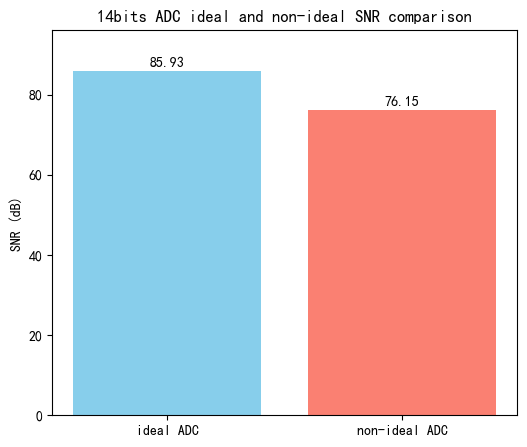

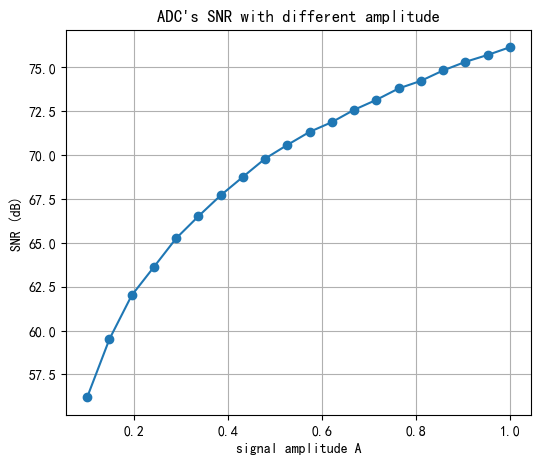

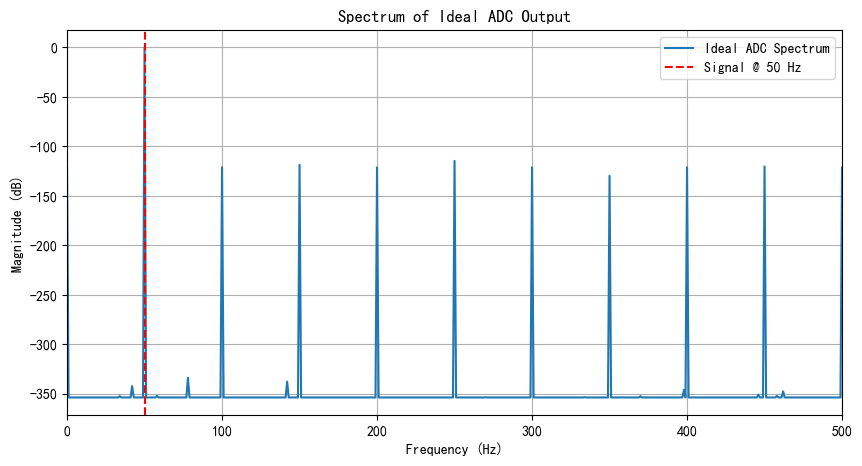

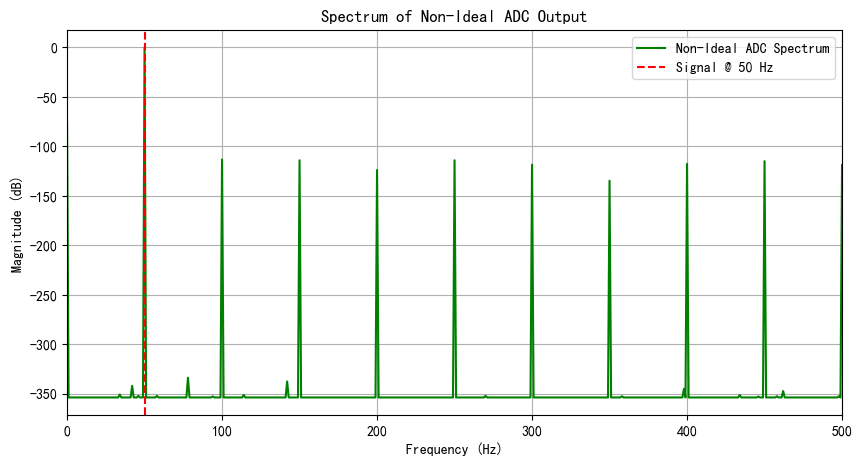

In [9]:
def second_add_errors_model():
    bits = 14                  
    full_scale = 1.0           
    N = 1000000                 
    f_signal = 50              
    t = np.linspace(0, 1, N, endpoint=False)

    x = full_scale * np.sin(2 * np.pi * f_signal * t)

    Q = 2 * full_scale / (2**bits)

    x_quant_ideal = np.clip(np.round(x / Q) * Q, -full_scale, full_scale - Q)

    error_ideal = x - x_quant_ideal
    signal_power = np.mean(x**2)
    noise_power_ideal = np.mean(error_ideal**2)
    snr_simulated_ideal = 10 * np.log10(signal_power / noise_power_ideal)
    snr_theoretical = 6.02 * bits + 1.76  

    print("【ideal ADC】")
    print("simulation SNR: {:.2f} dB".format(snr_simulated_ideal))
    print("theoritical SNR: {:.2f} dB".format(snr_theoretical))


    offset = 0.7 * Q
    mismatch_std = 0.5 * Q

    num_codes = 2**bits
    mismatch_table = np.random.normal(loc=0.0, scale=mismatch_std, size=num_codes)

    def adc_nonideal(x_input, Q, offset, mismatch_table, bits):
        min_code = -2**(bits-1)
        max_code = 2**(bits-1) - 1
        code = np.round(x_input / Q)
        code = np.clip(code, min_code, max_code).astype(int)
        
        indices = code - min_code
        mismatch_err = mismatch_table[indices]
        
        adc_output = code * Q + offset + mismatch_err
        return adc_output

    x_quant_nonideal = adc_nonideal(x, Q, offset, mismatch_table, bits)

    error_nonideal = x - x_quant_nonideal
    noise_power_nonideal = np.mean(error_nonideal**2)
    snr_simulated_nonideal = 10 * np.log10(signal_power / noise_power_nonideal)

    print("\n【non-ideal ADC with offset and mismatch】")
    print("simulation SNR: {:.2f} dB".format(snr_simulated_nonideal))

    plt.figure(figsize=(6,5))
    bars = plt.bar(["ideal ADC", "non-ideal ADC"], 
                [snr_simulated_ideal, snr_simulated_nonideal], 
                color=['skyblue','salmon'])
    plt.ylabel("SNR (dB)")
    plt.title("14bits ADC ideal and non-ideal SNR comparison")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom')
    plt.ylim(0, max(snr_theoretical, snr_simulated_nonideal) + 10)
    plt.show()

    amplitudes = np.linspace(0.1*full_scale, full_scale, 20)
    snr_values_nonideal = []

    for A in amplitudes:
        x_A = A * np.sin(2 * np.pi * f_signal * t)
        x_quant_A = adc_nonideal(x_A, Q, offset, mismatch_table, bits)
        error_A = x_A - x_quant_A
        signal_power_A = np.mean(x_A**2)
        noise_power_A = np.mean(error_A**2)
        snr_A = 10 * np.log10(signal_power_A / noise_power_A)
        snr_values_nonideal.append(snr_A)

    plt.figure(figsize=(6,5))
    plt.plot(amplitudes, snr_values_nonideal, marker='o')
    plt.xlabel("signal amplitude A")
    plt.ylabel("SNR (dB)")
    plt.title("ADC's SNR with different amplitude")
    plt.grid(True)
    plt.show()

    eps = 1e-12

    X_fft_ideal = np.fft.fft(x_quant_ideal)
    freqs = np.fft.fftfreq(N, d=1.0/N)
    indices = freqs >= 0  
    freqs_pos = freqs[indices]
    X_mag_ideal = np.abs(X_fft_ideal[indices])
    max_val_ideal = np.max(np.clip(X_mag_ideal, eps, None))
    X_mag_dB_ideal = 20 * np.log10(np.clip(X_mag_ideal, eps, None) / max_val_ideal)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs_pos, X_mag_dB_ideal, label="Ideal ADC Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Spectrum of Ideal ADC Output")
    plt.xlim(0, 500)
    plt.axvline(f_signal, color='red', linestyle='--', label=f"Signal @ {f_signal} Hz")
    plt.legend()
    plt.grid(True)
    plt.show()

    X_fft_nonideal = np.fft.fft(x_quant_nonideal)
    X_mag_nonideal = np.abs(X_fft_nonideal[indices])
    max_val_nonideal = np.max(np.clip(X_mag_nonideal, eps, None))
    X_mag_dB_nonideal = 20 * np.log10(np.clip(X_mag_nonideal, eps, None) / max_val_nonideal)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs_pos, X_mag_dB_nonideal, color='green', label="Non-Ideal ADC Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Spectrum of Non-Ideal ADC Output")
    plt.xlim(0, 500)
    plt.axvline(f_signal, color='red', linestyle='--', label=f"Signal @ {f_signal} Hz")
    plt.legend()
    plt.grid(True)
    plt.show()

second_add_errors_model()


### 3. Pyroch model and calibrate the ADCs (worked)

【non-calibrated split ADC】
original output SNR: 78.13 dB
Epoch 10: Loss = 0.000000
Epoch 20: Loss = 0.000000
Epoch 30: Loss = 0.000000
Epoch 40: Loss = 0.000000
Epoch 50: Loss = 0.000000
Epoch 60: Loss = 0.000000
Epoch 70: Loss = 0.000000
Epoch 80: Loss = 0.000000
Epoch 90: Loss = 0.000000
Epoch 100: Loss = 0.000000

【calibrated split ADC】
after calibration output SNR: 83.52 dB
after calibration SNR increases 5.39 dB


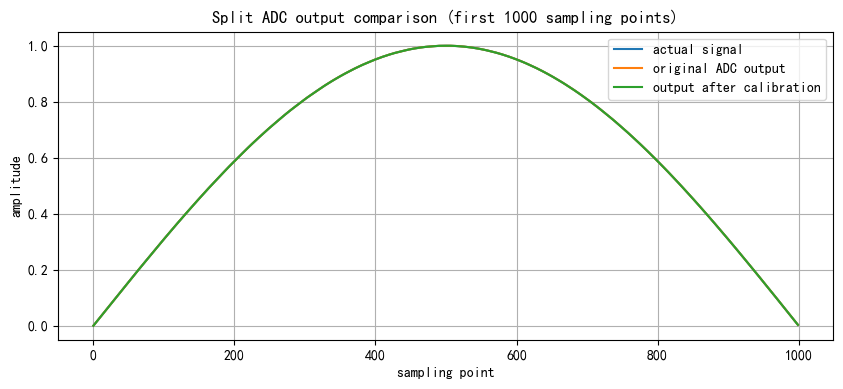

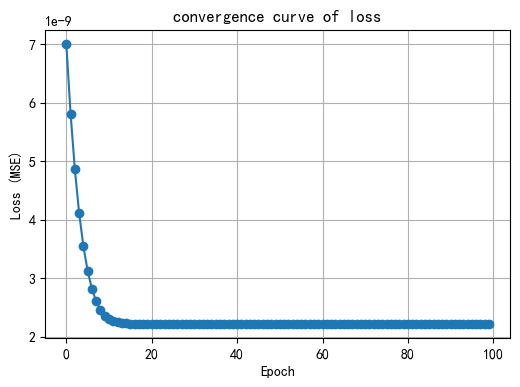

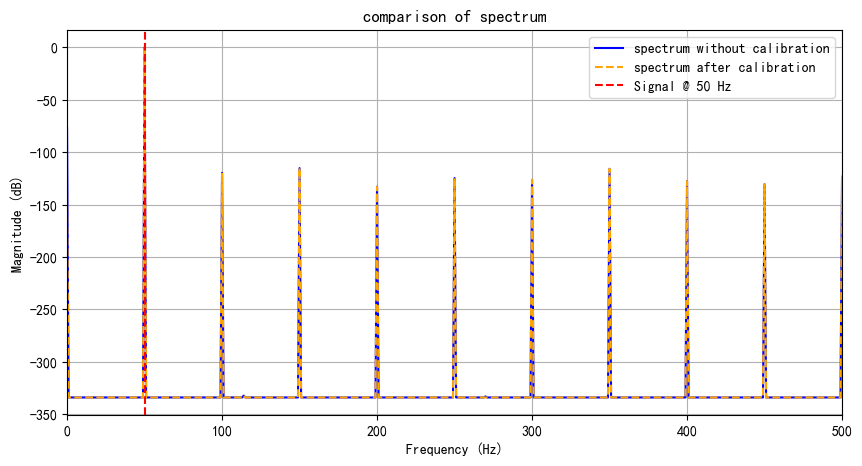

In [10]:
def third_train_model_and_test_SNR():
    np.random.seed(0)
    torch.manual_seed(0)

    bits = 14                   
    full_scale = 1.0             
    N = 100000                
    f_signal = 50                
    t = np.linspace(0, 1, N, endpoint=False)
    x = full_scale * np.sin(2 * np.pi * f_signal * t)  

    Q = 2 * full_scale / (2**bits)


    def adc_nonideal(x_input, Q, offset, mismatch_table, bits):
        min_code = -2**(bits-1)
        max_code = 2**(bits-1) - 1

        code = np.round(x_input / Q)
        code = np.clip(code, min_code, max_code).astype(int)

        indices = code - min_code
        mismatch_err = mismatch_table[indices]
        adc_output = code * Q + offset + mismatch_err
        return adc_output


    num_codes = 2**bits

    offset_A = 0.5 * Q
    mismatch_std_A = 0.2 * Q
    mismatch_table_A = np.random.normal(loc=0.0, scale=mismatch_std_A, size=num_codes)

    offset_B = 0.7 * Q
    mismatch_std_B = 0.5 * Q
    mismatch_table_B = np.random.normal(loc=0.0, scale=mismatch_std_B, size=num_codes)

    y_A = adc_nonideal(x, Q, offset_A, mismatch_table_A, bits)
    y_B = adc_nonideal(x, Q, offset_B, mismatch_table_B, bits)
    y_raw = 0.5 * (y_A + y_B)

    def compute_snr(signal, output):
        noise = signal - output
        return 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))

    snr_raw = compute_snr(x, y_raw)
    print("【non-calibrated split ADC】")
    print("original output SNR: {:.2f} dB".format(snr_raw))


    class ConstantCalibration(nn.Module):
        def __init__(self):
            super(ConstantCalibration, self).__init__()
            self.bias = nn.Parameter(torch.zeros(1))
            
        def forward(self, x):
            return self.bias.expand_as(x)

    class CalibrationModel(nn.Module):
        def __init__(self):
            super(CalibrationModel, self).__init__()
            self.calib_A = ConstantCalibration()
            self.calib_B = ConstantCalibration()
            
        def forward(self, y_A, y_B):
            delta_A = self.calib_A(y_A)
            delta_B = self.calib_B(y_B)
            y_A_cal = y_A + delta_A
            y_B_cal = y_B + delta_B
            y_cal = 0.5 * (y_A_cal + y_B_cal)
            return y_cal

    train_in_A = torch.from_numpy(y_A.astype(np.float32)).unsqueeze(1)
    train_in_B = torch.from_numpy(y_B.astype(np.float32)).unsqueeze(1)
    train_target = torch.from_numpy(x.astype(np.float32)).unsqueeze(1)

    model = CalibrationModel()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0000001) 

    num_epochs = 100 
    batch_size = 1024
    num_batches = int(np.ceil(N / batch_size))
    loss_list = []

    for epoch in range(num_epochs):
        permutation = torch.randperm(N)
        epoch_loss = 0.0
        for i in range(num_batches):
            indices = permutation[i * batch_size:(i + 1) * batch_size]
            batch_in_A = train_in_A[indices]
            batch_in_B = train_in_B[indices]
            batch_target = train_target[indices]
            
            optimizer.zero_grad()
            output = model(batch_in_A, batch_in_B)
            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        epoch_loss /= num_batches
        loss_list.append(epoch_loss)
        if (epoch+1) % 10 == 0:
            print("Epoch {}: Loss = {:.6f}".format(epoch + 1, epoch_loss))

    model.eval()
    with torch.no_grad():
        y_calibrated = model(train_in_A, train_in_B).squeeze(1).numpy()

    snr_calibrated = compute_snr(x, y_calibrated)
    print("\n【calibrated split ADC】")
    print("after calibration output SNR: {:.2f} dB".format(snr_calibrated))
    if snr_calibrated > snr_raw:
        print("after calibration SNR increases {:.2f} dB".format(snr_calibrated - snr_raw))
    else:
        print("SNR didn't increase, please check the learning rate or epochs")

    plt.figure(figsize=(10, 4))
    plt.plot(x[:1000], label='actual signal')
    plt.plot(y_raw[:1000], label='original ADC output')
    plt.plot(y_calibrated[:1000], label='output after calibration')
    plt.xlabel('sampling point')
    plt.ylabel('amplitude')
    plt.title('Split ADC output comparison (first 1000 sampling points)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制训练过程中损失的收敛曲线
    plt.figure(figsize=(6, 4))
    plt.plot(loss_list, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("convergence curve of loss")
    plt.grid(True)
    plt.show()

    eps = 1e-12

    X_fft_raw = np.fft.fft(y_raw)
    freqs = np.fft.fftfreq(N, d=1.0/N)
    indices = freqs >= 0
    freqs_pos = freqs[indices]
    X_mag_raw = np.abs(X_fft_raw[indices])
    max_val_raw = np.max(np.clip(X_mag_raw, eps, None))
    X_mag_raw_dB = 20 * np.log10(np.clip(X_mag_raw, eps, None) / max_val_raw)

    X_fft_cal = np.fft.fft(y_calibrated)
    X_mag_cal = np.abs(X_fft_cal[indices])
    max_val_cal = np.max(np.clip(X_mag_cal, eps, None))
    X_mag_cal_dB = 20 * np.log10(np.clip(X_mag_cal, eps, None) / max_val_cal)

    plt.figure(figsize=(10, 5))
    plt.plot(freqs_pos, X_mag_raw_dB, label="spectrum without calibration", color='blue')
    plt.plot(freqs_pos, X_mag_cal_dB, label="spectrum after calibration", color='orange', linestyle='--')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("comparison of spectrum")
    plt.xlim(0, 500)
    plt.axvline(f_signal, color='red', linestyle='--', label=f"Signal @ {f_signal} Hz")
    plt.legend()
    plt.grid(True)
    plt.show()

third_train_model_and_test_SNR()
